## Data Loading & Processing
- Data loading: voting matrix V, distance matrix D
- Normalizing: V_norm(i, j) = V(i, j) / sum_{k=1 to n} V(i, k), D_norm (i, j) = (D(i, j) - min(D)) / (max(D) - min(D))

Countries that don't occur in distances.csv are removed from country_info.csv to obtain country_info_aligned.csv <br>
Rows and columns in V and D are organized in the same order with countries in country_info_aligned.csv

In [ ]:
# Data Loading & Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from pandas import DataFrame
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

country_info_path = "../data/country_info_aligned.csv"
distances_path = "../data/distances.csv"
votes_path = "../data/votes.csv"

# create voting matrix V and distance matrix D 

# distance matrix D
# organize in order according to country_info file (left -> right, up -> down)
country_info_df = pd.read_csv(country_info_path)
map_name_to_idx, map_code_to_idx, map_capital_to_idx = {}, {}, {}
country_info_array = np.array(country_info_df) 
country_info_list = country_info_array.tolist()  
for idx, country in enumerate(country_info_list):
    map_name_to_idx[country[0]], map_code_to_idx[country[1]], map_capital_to_idx[country[2]]  = idx, idx, idx


distances_df = pd.read_csv(distances_path)
distances_array = np.array(distances_df)
distances_list = distances_array[:, 1:].tolist()
old_order = distances_array[:, 0]
map_old_order_to_idx = {capital:idx for idx, capital in enumerate(old_order)}
country_num = len(old_order)
# (i, j) -> (i', j') in old_order -> distance(i', j') in distances_list
distances_list_in_new_order = [[
    distances_list[map_old_order_to_idx[country_info_list[j][2]]][map_old_order_to_idx[country_info_list[i][2]]] 
    for j in range(country_num)] for i in range(country_num)]
distance_matrix = distances_list_in_new_order

# normalize
def normalize_2d_list(matrix):
    normalized_matrix = []
    for row in matrix:
        row_sum = sum(row)
        if row_sum == 0:
            normalized_matrix.append([0] * len(row))
        else:
            normalized_row = [element / row_sum for element in row]
            normalized_matrix.append(normalized_row)
    return normalized_matrix

distance_matrix_norm = normalize_2d_list(distance_matrix)


# voting matrix V
# only consider 2023, final and total points in this sample
# omit other countries wld
votes_df = pd.read_csv(votes_path)
votes_array = np.array(votes_df) 
votes_list = votes_array.tolist()  

votes_matrix = [[0 for i in range(country_num)] for j in range(country_num)]

for vote in votes_list:
    if vote[0] != 2023 or vote[1] != 'final':
        continue
    from_country_code, to_country_code, tatol_points = vote[2], vote[3], vote[-3]
    if from_country_code == 'wld' or to_country_code == 'wld':
        continue
    votes_matrix[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += tatol_points

# normalize
vote_matrix_norm = normalize_2d_list(votes_matrix)

## Clustering
- clustering by countries <br>
Each row of D and V can be seen as a country.  cluster by rows...
- clustering by country-country pairs <br>
Each element of D and V can be seen as a country-country pair.  cluster by elements...

In [75]:
def cluster_by_countries_and_visualize_by_pca(D, V, num_clusters):
    D = np.array(D)
    V = np.array(V)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(D)  # 在D数据上应用聚类
    #print(labels)

    pca_V = PCA(n_components=2)
    pca_D = PCA(n_components=2)

    V_pca = pca_V.fit_transform(V)
    D_pca = pca_D.fit_transform(D)

    silhouette_avg = silhouette_score(D, labels)
    print(f"The silhouette score for D data is: {silhouette_avg}")
    silhouette_avg = silhouette_score(V, labels)
    print(f"The silhouette score for V data is: {silhouette_avg}")

    random_labels = np.random.randint(num_clusters, size=len(D))
    random_silhouette_D = silhouette_score(D, random_labels)
    random_silhouette_V = silhouette_score(V, random_labels)
    print(f"The silhouette score for random clustering on D data is: {random_silhouette_D}")
    print(f"The silhouette score for random clustering on V data is: {random_silhouette_V}")


    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for cluster in range(num_clusters):
        cluster_points = D_pca[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of D')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.subplot(1, 2, 2)
    for cluster in range(num_clusters):
        cluster_points = V_pca[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of V')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.tight_layout()
    plt.show()


def cluster_by_country_pairs_and_visualize(D, V, num_clusters):
    V = np.array(V)
    D = np.array(D)

    D_flat = D.flatten().reshape(-1, 1)
    V_flat = V.flatten().reshape(-1, 1)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(D_flat)

    labels_matrix = labels.reshape(D.shape)

    silhouette_D = silhouette_score(D_flat, labels)
    print(f"The silhouette score for D data is: {silhouette_D}")
    silhouette_V = silhouette_score(V_flat, labels)
    print(f"The silhouette score for V data is: {silhouette_V}")

    random_labels = np.random.randint(num_clusters, size=len(D_flat))
    random_silhouette_D = silhouette_score(D_flat, random_labels)
    random_silhouette_V = silhouette_score(V_flat, random_labels)
    print(f"The silhouette score for random clustering on D data is: {random_silhouette_D}")
    print(f"The silhouette score for random clustering on V data is: {random_silhouette_V}")

    # Visualizing D using a scatter plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_data = D_flat[labels == label]
        plt.scatter(label_data, np.zeros_like(label_data), label=f'Cluster {label}', alpha=0.6)

    plt.title('Scatter Plot Visualization of D')
    plt.xlabel('Data Value')
    plt.yticks([])  # Hide y-axis ticks
    plt.legend()

    # Visualizing V based on D clusters using a scatter plot
    plt.subplot(1, 2, 2)
    for label in unique_labels:
        label_data = V_flat[labels == label]
        plt.scatter(label_data, np.zeros_like(label_data), label=f'Cluster {label}', alpha=0.6)

    plt.title('Scatter Plot Visualization of V Based on D Clusters')
    plt.xlabel('Data Value')
    plt.yticks([])  # Hide y-axis ticks
    plt.legend()

    plt.tight_layout()
    plt.show()


The silhouette score for D data is: 0.3460615079516532
The silhouette score for V data is: -0.011407062541975719
The silhouette score for random clustering on D data is: -0.03957212819308459
The silhouette score for random clustering on V data is: -0.03345892372469699


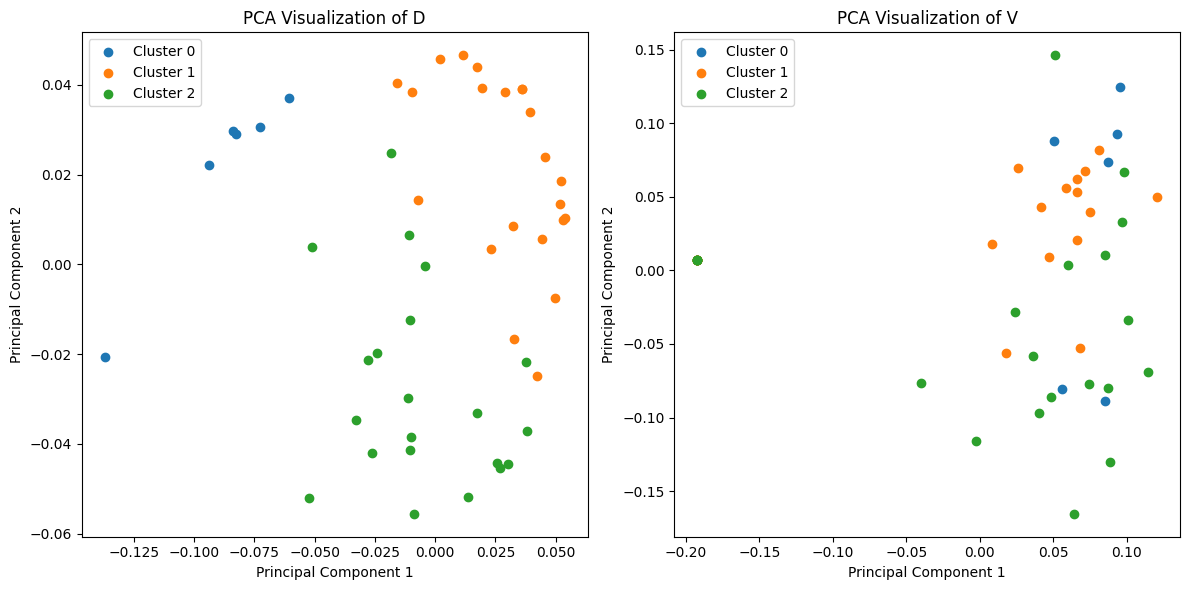

The silhouette score for D data is: 0.38744231177262584
The silhouette score for V data is: -0.04675181466635887
The silhouette score for random clustering on D data is: -0.08633988473861878
The silhouette score for random clustering on V data is: -0.04356076091234868


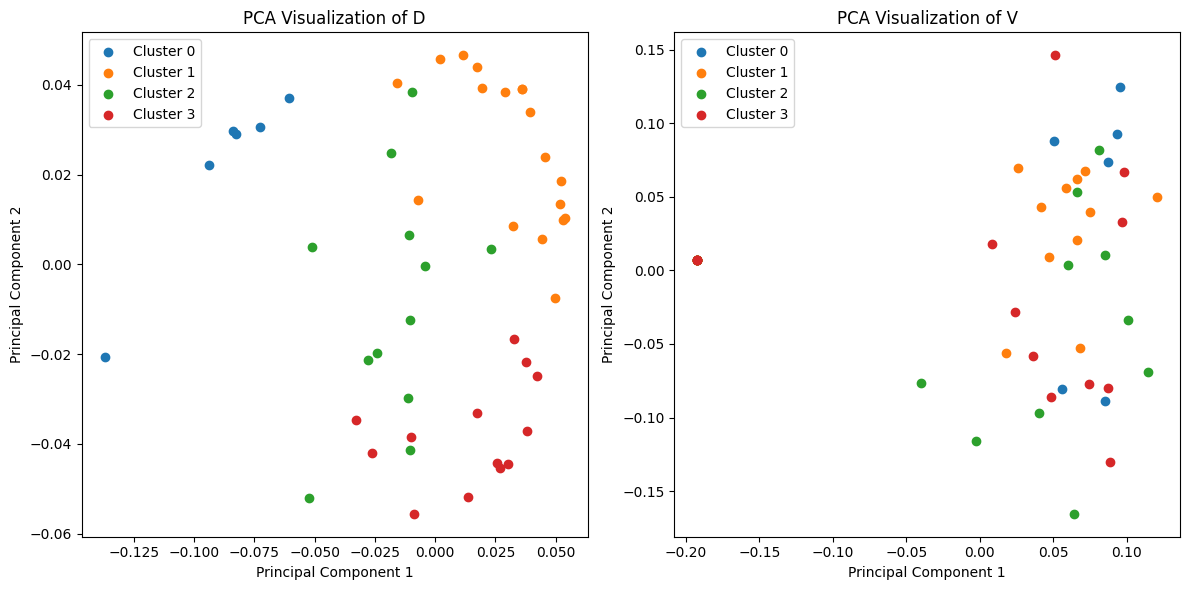

The silhouette score for D data is: 0.3606880392839815
The silhouette score for V data is: -0.06824609375163673
The silhouette score for random clustering on D data is: -0.08768223710261884
The silhouette score for random clustering on V data is: -0.05711079001711141


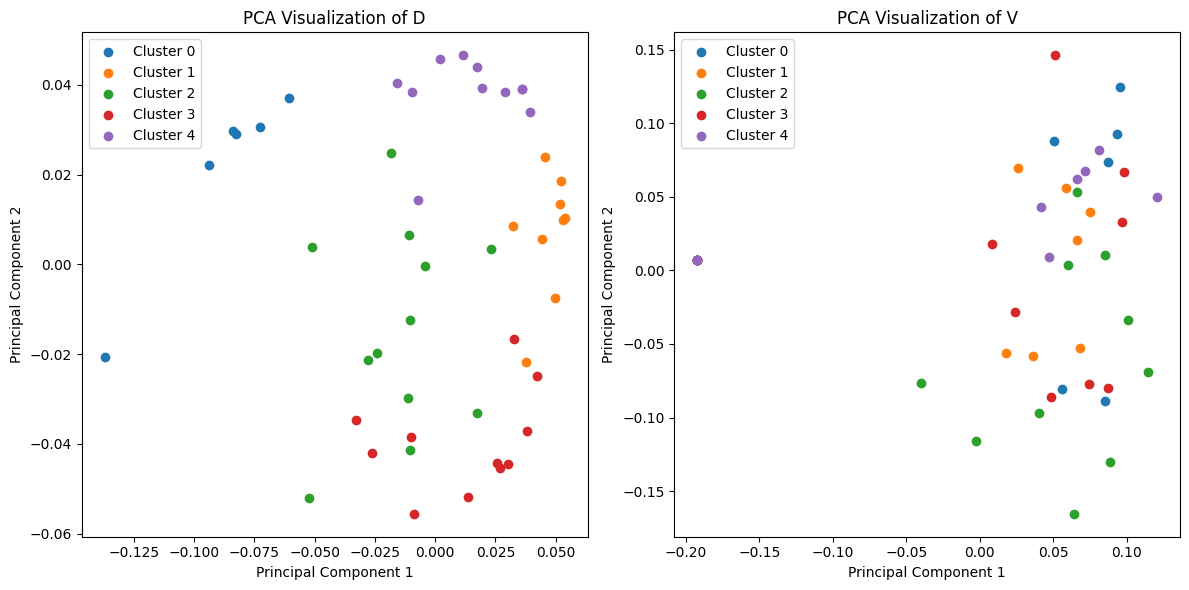

The silhouette score for D data is: 0.310637151077654
The silhouette score for V data is: -0.10616102334133296
The silhouette score for random clustering on D data is: -0.1852318796530305
The silhouette score for random clustering on V data is: -0.10362815626012373


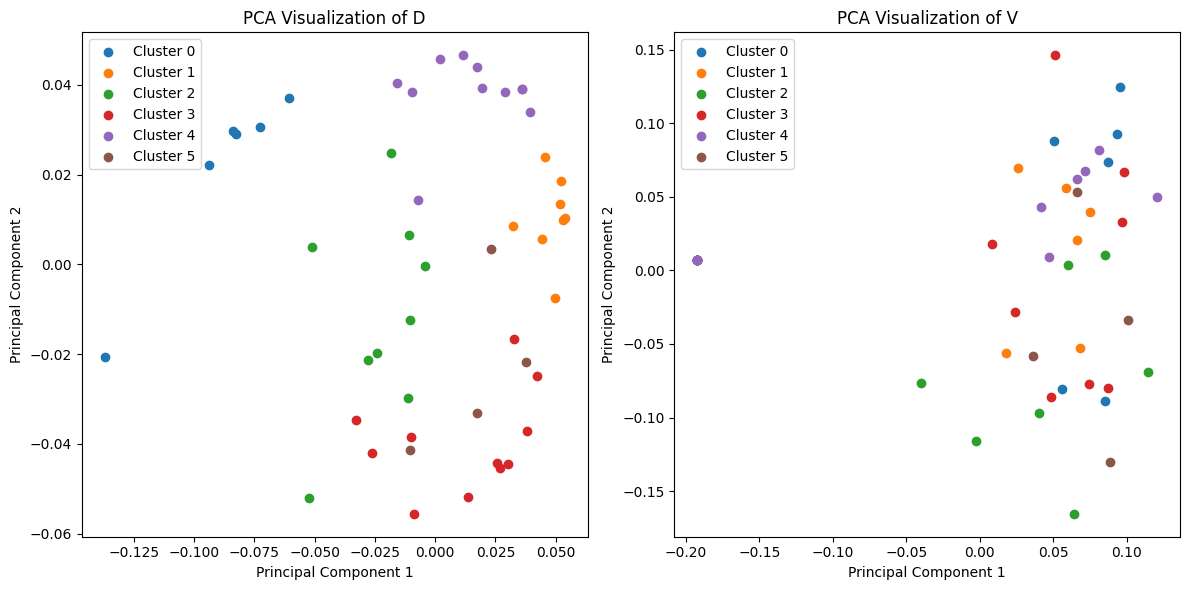

In [76]:
cluster_by_countries_and_visualize_by_pca(distance_matrix_norm, vote_matrix_norm, 3)
cluster_by_countries_and_visualize_by_pca(distance_matrix_norm, vote_matrix_norm, 4)
cluster_by_countries_and_visualize_by_pca(distance_matrix_norm, vote_matrix_norm, 5)
cluster_by_countries_and_visualize_by_pca(distance_matrix_norm, vote_matrix_norm, 6)

The silhouette score for D data is: 0.5416321205051557
The silhouette score for V data is: -0.040627227656332254
The silhouette score for random clustering on D data is: -0.027799197316633283
The silhouette score for random clustering on V data is: -0.05778460605917155


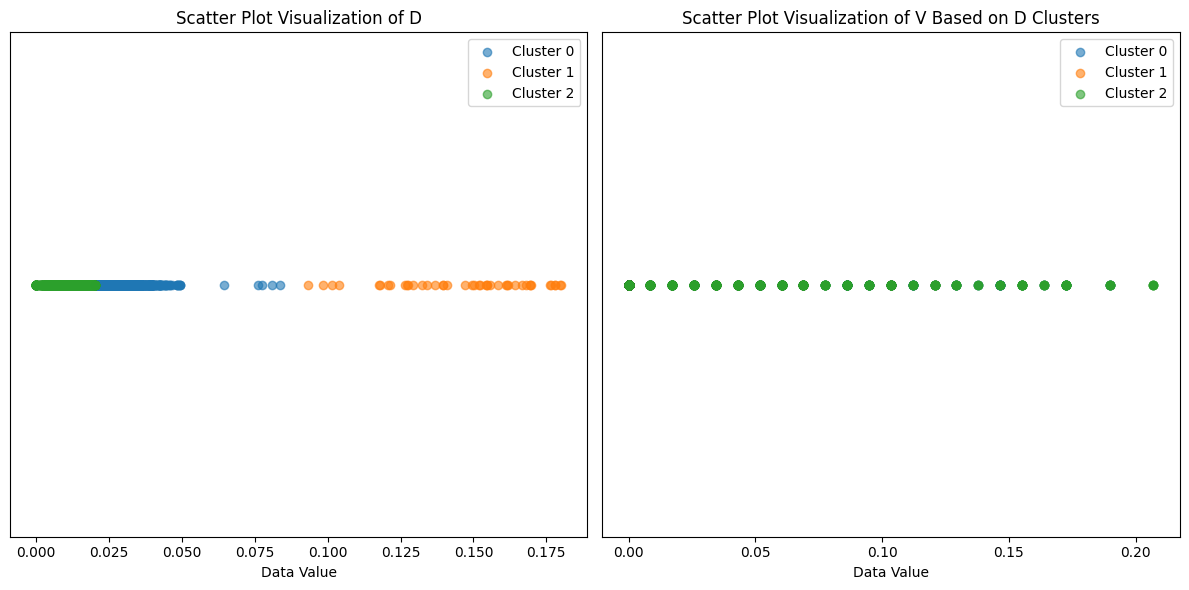

The silhouette score for D data is: 0.5579150925984376
The silhouette score for V data is: -0.17668980390703942
The silhouette score for random clustering on D data is: -0.04092476866553139
The silhouette score for random clustering on V data is: -0.011784930468194132


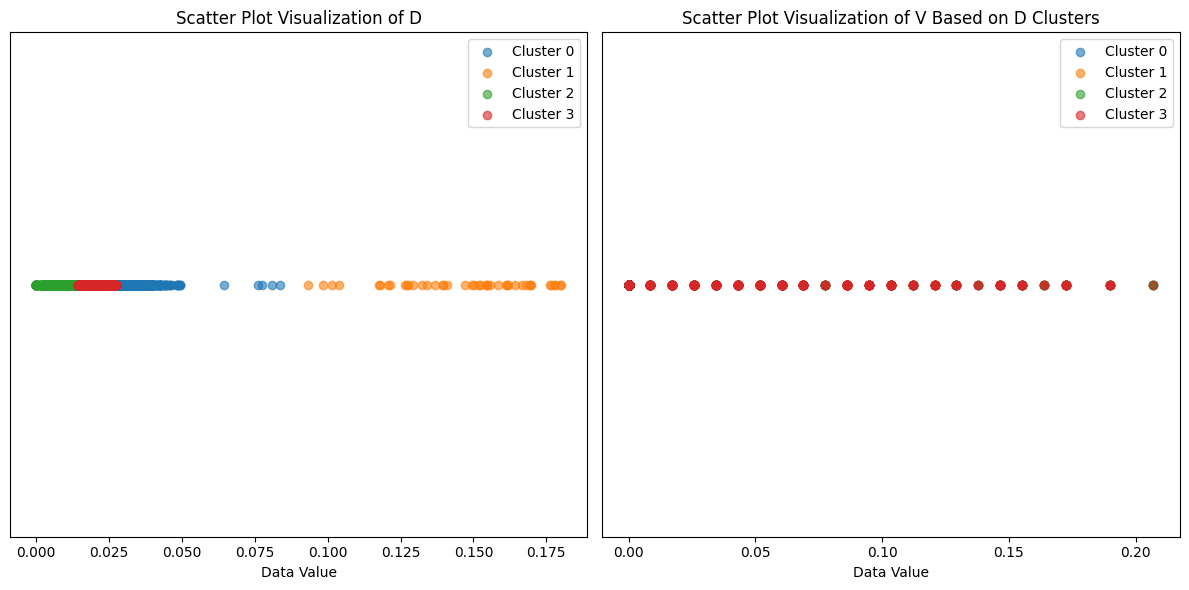

The silhouette score for D data is: 0.5566041077691958
The silhouette score for V data is: -0.19314675734202666
The silhouette score for random clustering on D data is: -0.05614986673517042
The silhouette score for random clustering on V data is: -0.08345787461709833


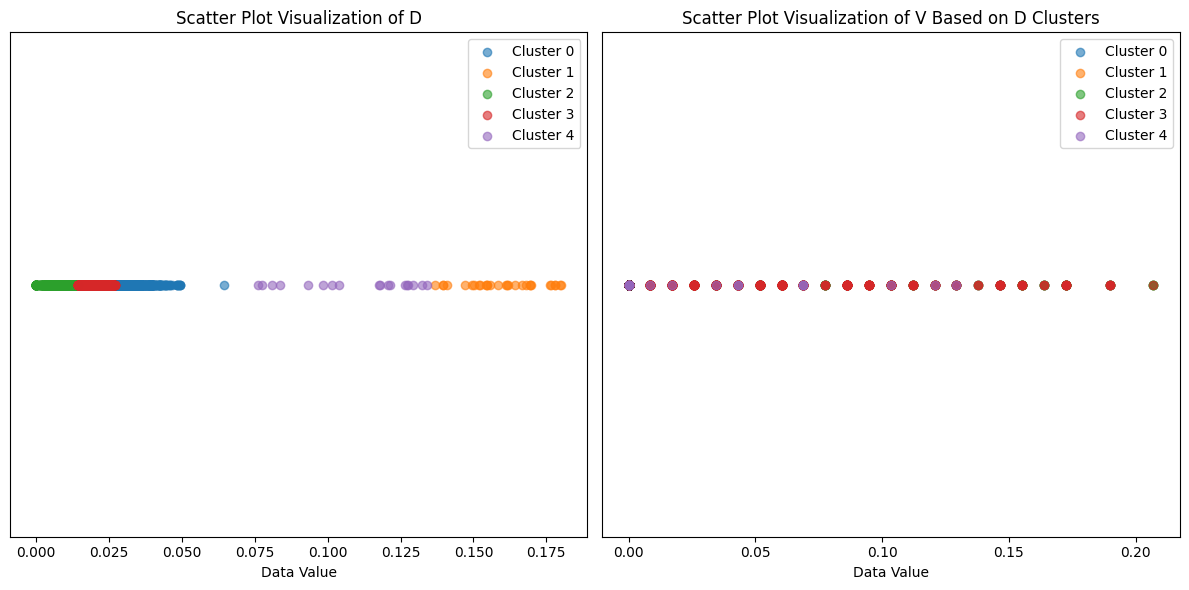

The silhouette score for D data is: 0.5569546545237378
The silhouette score for V data is: -0.1940618419219072
The silhouette score for random clustering on D data is: -0.06402004381732375
The silhouette score for random clustering on V data is: -0.09653306121468784


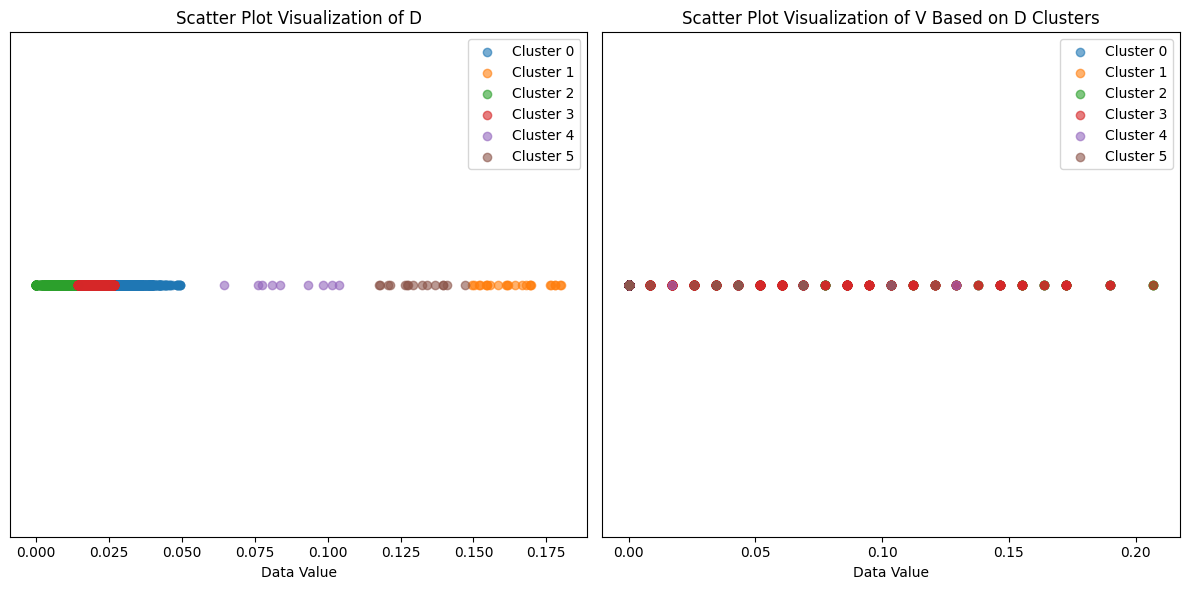

In [77]:
cluster_by_country_pairs_and_visualize(distance_matrix_norm, vote_matrix_norm, 3)
cluster_by_country_pairs_and_visualize(distance_matrix_norm, vote_matrix_norm, 4)
cluster_by_country_pairs_and_visualize(distance_matrix_norm, vote_matrix_norm, 5)
cluster_by_country_pairs_and_visualize(distance_matrix_norm, vote_matrix_norm, 6)